In [27]:
#!pip install spacy
# !python -m spacy download en_core_web_sm

In [34]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from itertools import chain
import matplotlib.pyplot as plt
import spacy
from spacy import displacy

import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model
from numpy.random import seed

# ebablbe auto-completion
%config Completer.use_jedi = False

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [3]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./Learner_Notebook.ipynb
./ner_dataset.csv
./ner-with-bilstm.ipynb
./model.png
./.ipynb_checkpoints/Learner_Notebook-checkpoint.ipynb
./.ipynb_checkpoints/ner-with-bilstm-checkpoint.ipynb


In [4]:
data = pd.read_csv('./ner_dataset.csv', encoding= 'unicode_escape')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [5]:
data.shape

(1048575, 4)

In [6]:
data.isna().any()

Sentence #     True
Word          False
POS           False
Tag           False
dtype: bool

In [7]:
def get_dict_map(data, token_or_tag):
    tok2idx = {}
    idx2tok = {}
    
    if token_or_tag == 'token':
        vocab = list(set(data['Word'].to_list()))
    else:
        vocab = list(set(data['Tag'].to_list()))
    
    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok


token2idx, idx2token = get_dict_map(data, 'token')
tag2idx, idx2tag = get_dict_map(data, 'tag')

In [8]:
data['Word_idx'] = data['Word'].map(token2idx)
data['Tag_idx'] = data['Tag'].map(tag2idx)

In [9]:
# 采用上一个非空值，填充空值。
data_fillna = data.fillna(method='ffill', axis=0)
data_group = data_fillna.groupby(['Sentence #'],as_index=False
                                )['Word', 'POS', 'Tag', 'Word_idx', 'Tag_idx'].agg(lambda x: list(x))

print(len(data_group))
data_group.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


47959


,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","[7622, 25994, 7134, 16992, 12777, 15147, 25148...","[2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 4, 2, 2, ..."
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[29101, 22612, 22870, 16889, 32907, 12932, 706...","[16, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,..."
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...","[3771, 11584, 25406, 19906, 19338, 21470, 1107...","[2, 2, 15, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 12..."
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]","[14990, 19058, 26914, 10945, 33220, 12725, 611...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]"
4,Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, J...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...","[28704, 11079, 29606, 7385, 25795, 26308, 2397...","[4, 2, 2, 11, 8, 2, 15, 2, 4, 2, 16, 2, 16, 2,..."


In [10]:
def get_pad_train_test_val(data_group, data):
    n_token = len(list(set(data['Word'].to_list())))
    n_tag = len(list(set(data['Tag'].to_list())))
    
    tokens = data_group['Word_idx'].tolist()
    maxlen = max([len(s) for s in tokens])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)
    
    tags = data_group['Tag_idx'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
    
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]
    
    
    train_tokens, test_tokens, train_tags, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)

    print(
        'train_tokens shape:', train_tokens.shape,
        '\ntest_tokens shape:', test_tokens.shape,
        '\ntrain_tags shape:', len(train_tags),
        '\ntest_tags shape:', len(test_tags)
    )
    
    return train_tokens, test_tokens, train_tags, test_tags

train_tokens, test_tokens, train_tags, test_tags = get_pad_train_test_val(data_group, data)

train_tokens shape: (43163, 104) 
test_tokens shape: (4796, 104) 
train_tags shape: 43163 
test_tags shape: 4796


In [11]:
for token, tag in zip(train_tokens[0], train_tags[0]):
    print('%s\t%s' % (token, tag))

8723	[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
22870	[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
19707	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
10393	[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
17324	[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
22497	[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
12932	[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
33210	[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
21452	[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
28839	[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
20447	[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
5069	[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
16889	[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
29898	[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
19237	[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
31153	[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
32236	[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

In [12]:
input_dim = len(list(set(data['Word'].to_list())))+1
output_dim = 32
input_length = max([len(s) for s in data_group['Word_idx'].tolist()])
n_tags = len(tag2idx)
print('input_dim: ', input_dim, '\noutput_dim: ', output_dim, '\ninput_length: ', input_length, '\nn_tags: ', n_tags)

input_dim:  35179 
output_dim:  32 
input_length:  104 
n_tags:  17


In [13]:
seed(1)
tf.random.set_seed(2)

In [14]:
def get_bilstm_lstm_model():
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'))
    model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))
    model.add(TimeDistributed(Dense(n_tags, activation="relu")))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [15]:
def train_model(X, y, model):
    loss = list()
    for _ in range(25):
        # fit model for one epoch on this sequence
        hist = model.fit(X, y, batch_size=1000, verbose=1, epochs=1, validation_split=0.2)
        loss.append(hist.history['loss'][0])
    return loss
model_bilstm_lstm = get_bilstm_lstm_model()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 104, 32)           1125728   
_________________________________________________________________
bidirectional (Bidirectional (None, 104, 64)           16640     
_________________________________________________________________
lstm_1 (LSTM)                (None, 104, 32)           12416     
_________________________________________________________________
time_distributed (TimeDistri (None, 104, 17)           561       
Total params: 1,155,345
Trainable params: 1,155,345
Non-trainable params: 0
_________________________________________________________________


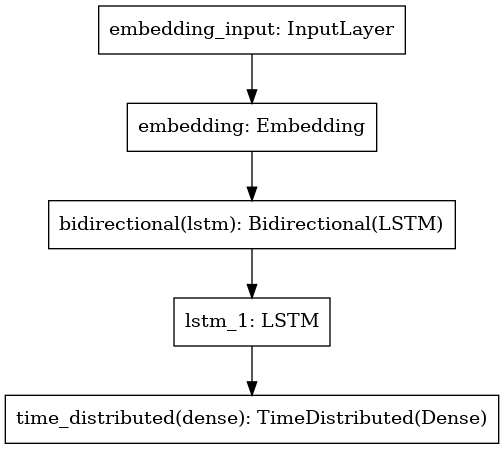

In [16]:
plot_model(model_bilstm_lstm)

In [17]:
results = pd.DataFrame()
results['with_add_lstm'] = train_model(train_tokens, np.array(train_tags), model_bilstm_lstm)

35/35 [==============================] - 52s 1s/step - loss: 0.1244 - accuracy: 0.9677 - val_loss: 0.1280 - val_accuracy: 0.9679


Text(0, 0.5, 'Loss')

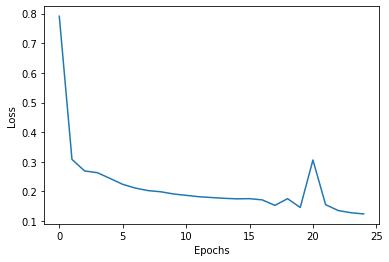

In [19]:
plt.plot(results['with_add_lstm'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [146]:
sample_data = data_group.sample(5)
sentences = [words for words in sample_data['Word']]
tags = [tags for tags in sample_data['Tag']]
print(sentences)
print(tags)

[['His', 'Soviet-backed', 'Sandinista', 'government', 'also', 'fought', 'a', 'lengthy', 'war', 'against', 'U.S.-backed', 'Contra', 'rebels', '.'], ['The', 'Sri', 'Lankan', 'government', 'has', 'blamed', 'the', 'group', 'for', 'his', 'assassination', ',', 'a', 'charge', 'denied', 'by', 'the', 'Tamil', 'Tigers', '.'], ['He', 'was', 'fired', 'last', 'month', 'by', 'President', 'Olusegun', 'Obasanjo', 'during', 'a', 'televised', 'address', 'to', 'the', 'nation', '.'], ['They', 'are', 'the', 'first', 'reported', 'in', 'Burma', 'since', 'March', '2006', '.'], ['Fidel', 'Castro', 'has', 'not', 'been', 'seen', 'in', 'public', 'since', 'July', '2006', 'when', 'he', 'underwent', 'intestinal', 'surgery', '.']]
[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'B-org', 'I-org', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-org', 'I-org', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'B-per', 'I-per', 'I-per', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], [

In [147]:
n_token = len(list(set(data['Word'].to_list())))
n_tag = len(list(set(data['Tag'].to_list())))
maxlen = max([len(s) for s in data_group['Word_idx'].tolist()])

In [148]:
def predict(model, words, tags, token2idx=token2idx, idx2tag=idx2tag):
    tokens = np.array([[token2idx[token] for token in words]])
    tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)
    predictions = model.predict(tokens)
    predict_tag_ids = predictions[0].argmax(axis=-1)
    predict_tags = [idx2tag[tag_id] for tag_id in predict_tag_ids]
    results = [(word, tag, predict_tags)for word, tag, predict_tags in zip(words, tags, predict_tags)]
    print(results)
    
# predict(model_bilstm_lstm, sentences[2], tags[2])        
for words, tag in zip(sentences, tags):
    print('-'*50)
    print(f'words = {words}')
    print(f'tag = {tag}')
    predict(model_bilstm_lstm, words, tag)

--------------------------------------------------
words = ['His', 'Soviet-backed', 'Sandinista', 'government', 'also', 'fought', 'a', 'lengthy', 'war', 'against', 'U.S.-backed', 'Contra', 'rebels', '.']
tag = ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[('His', 'O', 'O'), ('Soviet-backed', 'O', 'O'), ('Sandinista', 'O', 'O'), ('government', 'O', 'O'), ('also', 'O', 'O'), ('fought', 'O', 'O'), ('a', 'O', 'O'), ('lengthy', 'O', 'O'), ('war', 'O', 'O'), ('against', 'O', 'O'), ('U.S.-backed', 'O', 'O'), ('Contra', 'O', 'O'), ('rebels', 'O', 'O'), ('.', 'O', 'O')]
--------------------------------------------------
words = ['The', 'Sri', 'Lankan', 'government', 'has', 'blamed', 'the', 'group', 'for', 'his', 'assassination', ',', 'a', 'charge', 'denied', 'by', 'the', 'Tamil', 'Tigers', '.']
tag = ['O', 'B-org', 'I-org', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-org', 'I-org', 'O']
[('The', 'O', 'B-org'), ('Sri', 'B-org', 'B-org'), ('L

从上面的结果来看，效果非常不好啊。

In [28]:
nlp = spacy.load('en_core_web_sm')

In [149]:
note = 'Jim bought 300 shares of Acme Corp. in 2006. And producing an annotated block of text that \
    highlights the names of entities: [Jim]Person bought 300 shares of \
    [Acme Corp.]Organization in [2006]Time. In this example, a person name consisting \
    of one token, a two-token company name and a temporal expression have been detected \
    and classified.State-of-the-art NER systems for English produce near-human performance. \
    For example, the best system entering MUC-7 scored 93.39% of F-measure while human \
    annotators scored 97.60% and 96.95%.[1][2]'
note = 'Please order qty 1 J7Z09-67965 and qty 1 J7Z09-67970 NBD to my HAL in Lenexa.  Thank you.'
text = nlp(note) 

In [150]:
text

Please order qty 1 J7Z09-67965 and qty 1 J7Z09-67970 NBD to my HAL in Lenexa.  Thank you.

In [151]:
for w in text.ents:
    print(w.text, w.label_)

1 J7Z09-67965 DATE
1 J7Z09-67970 DATE
Lenexa GPE


In [152]:
displacy.render(text, style = 'ent', jupyter=True)

In [33]:
spacy.explain('CARDINAL')

'Numerals that do not fall under another type'